# Near real-time HF-Radar currents in the proximity of the Deepwater Horizon site

The explosion on the Deepwater Horizon (DWH) tragically killed 11 people, and resulted in one of the largest marine oil spills in history. One of the first questions when there is such a tragedy is: where will the oil go?

In order the help answer that question one can use Near real time currents from the HF-Radar sites near the incident.

First let's start with the [HF-Radar DAC](http://cordc.ucsd.edu/projects/mapping/maps/), where one can browser the all available data interactively. Below we show an IFrame with the area near DWH for the 27 of July of 2017.

In this notebook we will demonstrate how to obtain such data programmatically.

(For more information on the DWH see [http://response.restoration.noaa.gov/oil-and-chemical-spills/significant-incidents/deepwater-horizon-oil-spill](http://response.restoration.noaa.gov/oil-and-chemical-spills/significant-incidents/deepwater-horizon-oil-spill).)

In [1]:
from IPython.display import HTML

url = (
    'https://cordc.ucsd.edu/projects/mapping/maps/fullpage.php?'
    'll=29.061888,-87.373643&'
    'zm=7&'
    'mt=&'
    'rng=0.00,50.00&'
    'us=1&'
    'cs=4&'
    'res=6km_h&'
    'ol=3&'
    'cp=1'
)


iframe = '<iframe src="{src}" width="750" height="450" style="border:none;"></iframe>'.format

HTML(iframe(src=url))

/home/filipe/miniconda3/envs/IOOS/lib/python3.6/site-packages/IPython/core/display.py:689: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The interactive interface is handy for exploration but we usually need to download "mechanically" in order to use them in our analysis, plots, or for downloading time-series.

One way to achieve that is to use an OPeNDAP client, here Python's `xarray`, and explore the endpoint directly. 

(We'll use the same 6 km resolution from the IFrame above.)

In [2]:
import xarray as xr


url = (
    'http://hfrnet-tds.ucsd.edu/thredds/dodsC/HFR/USEGC/6km/hourly/RTV/'
    'HFRADAR_US_East_and_Gulf_Coast_6km_Resolution_Hourly_RTV_best.ncd'
)

ds = xr.open_dataset(url)
ds

<xarray.Dataset>
Dimensions:       (lat: 460, lon: 701, nProcParam: 7, nSites: 38, time: 60554)
Coordinates:
  * lat           (lat) float32 21.73596 21.7899 21.84384 ... 46.44048 46.49442
  * lon           (lon) float32 -97.88385 -97.825775 ... -57.289284 -57.23121
  * time          (time) datetime64[ns] 2012-01-01 ... 2018-11-30T10:00:00
    time_run      (time) datetime64[ns] ...
Dimensions without coordinates: nProcParam, nSites
Data variables:
    site_lat      (nSites) float32 ...
    site_lon      (nSites) float32 ...
    site_code     (nSites) |S64 ...
    site_netCode  (nSites) |S64 ...
    procParams    (nProcParam) float32 ...
    time_offset   (time) datetime64[ns] ...
    u             (time, lat, lon) float32 ...
    v             (time, lat, lon) float32 ...
    DOPx          (time, lat, lon) float32 ...
    DOPy          (time, lat, lon) float32 ...
Attributes:
    netcdf_library_version:  4.1.3
    format_version:          HFRNet_1.0.0
    product_version:         HFRN

How about extracting a week time-series from the dataset averaged around the area of interest?

In [3]:
dx = dy = 2.25  # Area around the point of interest.
center = -87.373643, 29.061888  # Point of interest.

dsw = ds.sel(time=slice('2017-07-20', '2017-07-27'))

In [4]:
dsw = dsw.sel(
    lon=(dsw.lon < center[0]+dx) & (dsw.lon > center[0]-dx),
    lat=(dsw.lat < center[1]+dy) & (dsw.lat > center[1]-dy),
)

With `xarray` we can average hourly (`resample`) the whole dataset with one method call.

In [5]:
resampled = dsw.resample(indexer={'time': '1H'})
avg = resampled.mean(dim='time')

/home/filipe/miniconda3/envs/IOOS/lib/python3.6/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Now all we have to do is mask the missing data with `NaN`s and average over the area.

In [6]:
import numpy.ma as ma

v = avg['v'].data
u = avg['u'].data
time = avg['time'].to_index().to_pydatetime()

u = ma.masked_invalid(u)
v = ma.masked_invalid(v)

In [7]:
i, j, k = u.shape

u = u.reshape(i, j*k).mean(axis=1)
v = v.reshape(i, j*k).mean(axis=1)

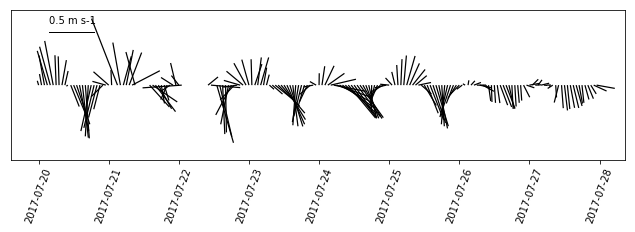

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from oceans.plotting import stick_plot

fig, ax = plt.subplots(figsize=(11, 2.75))

q = stick_plot(time, u, v, ax=ax)

ref = 0.5
qk = plt.quiverkey(q, 0.1, 0.85, ref,
                   '{} {}'.format(ref, ds['u'].units),
                   labelpos='N', coordinates='axes')

_ = plt.xticks(rotation=70)

To close this post let's us reproduce the HF radar DAC image from above but using yesterday's data.

In [9]:
from datetime import date, timedelta


yesterday = date.today() - timedelta(days=1)

dsy = ds.sel(time=yesterday)

Now that we singled out the date and and time we want the data, we trigger the download by accessing the data with `xarray`'s `.data` property.

In [10]:
u = dsy['u'].data
v = dsy['v'].data

lon = dsy.coords['lon'].data
lat = dsy.coords['lat'].data
time = dsy.coords['time'].data

The cell below computes the speed from the velocity. We can use the speed computation to color code the vectors. Note that we re-create the vector velocity preserving the direction but using intensity of `1`. (The same visualization technique used in the HF radar DAC.)

In [11]:
import numpy as np
from oceans.ocfis import uv2spdir, spdir2uv


angle, speed = uv2spdir(u, v)
us, vs = spdir2uv(np.ones_like(speed), angle, deg=True)

Now we can create a `matplotlib` figure displaying the data.

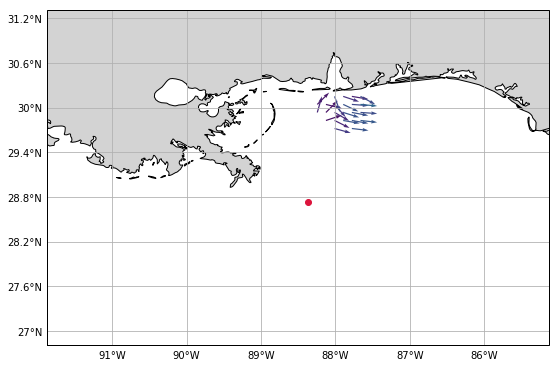

In [12]:
import cartopy.crs as ccrs

from cartopy import feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

LAND = feature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='face',
    facecolor='lightgray'
)

sub = 2
bbox = lon.min(), lon.max(), lat.min(), lat.max()

fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw=dict(projection=ccrs.PlateCarree())
)


ax.set_extent([center[0]-dx-dx, center[0]+dx, center[1]-dy, center[1]+dy])
vmin, vmax = np.nanmin(speed[::sub, ::sub]), np.nanmax(speed[::sub, ::sub])
speed_clipped = np.clip(speed[::sub, ::sub], 0, 0.65)
ax.quiver(
    lon[::sub], lat[::sub],
    us[::sub, ::sub], vs[::sub, ::sub],
    speed_clipped, scale=30,
)

# Deepwater Horizon site.
ax.plot(-88.365997, 28.736628, marker='o', color='crimson')
gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

feature = ax.add_feature(LAND, zorder=0, edgecolor='black')